In [1]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

from statsmodels.formula.api import ols

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam, Adamax

from tensorflow.keras.layers import Dense, Concatenate, Activation
from tensorflow.keras.metrics import RootMeanSquaredError
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

In [2]:
#aa = "A01"
#aa = "A02"
#aa = "A03"
#aa = "A04"
aa = "A05"
#aa = "A06"
A0=pd.read_csv(aa+".csv",encoding="utf-8-sig")

In [3]:
A0["de_dt"] = pd.to_datetime(A0["de_dt"].astype(int).astype(str))
A0

,cust,pd_c,cop_c,de_dt,de_hr,buy_am,ma_fem_dv,ages,pd_nm,clac_hlv_nm,clac_mcls_nm
0,M422782050,PD0548,A05,2021-01-01,9,378000.0,여성,50대,전기밥솥,생활/주방가전,주방가전
1,M396157873,PD0548,A05,2021-01-01,9,399000.0,여성,50대,전기밥솥,생활/주방가전,주방가전
2,M209959767,PD1675,A05,2021-01-01,11,60000.0,남성,60대,스피커,컴퓨터,컴퓨터주변기기
3,M209959767,PD1674,A05,2021-01-01,11,59000.0,남성,60대,소프트웨어,컴퓨터,컴퓨터주변기기
4,M209959767,PD1666,A05,2021-01-01,11,2360000.0,남성,60대,노트북,컴퓨터,컴퓨터/노트북
...,...,...,...,...,...,...,...,...,...,...,...
8176,M005209297,PD0418,A05,2021-12-31,19,139000.0,여성,50대,이어폰/헤드폰,모바일,모바일액세서리
8177,M729214437,PD0344,A05,2021-12-31,12,825000.0,남성,50대,일반세탁기,냉장/세탁가전,세탁기
8178,M256492589,PD0119,A05,2021-12-31,9,78000.0,여성,20대,히터,계절가전,난방가전
8179,M341197337,PD0027,A05,2021-12-31,9,118150.0,남성,30대,매트리스,가구,침실가구


# 전처리

## 점수 base 생성

In [4]:
#raitings : 고객 별 상품 구매 횟수 count (대분류는 덤으로!)
A0_tmp = A0.value_counts(['cust','pd_c',"de_dt","clac_mcls_nm","clac_hlv_nm"]).reset_index().rename(columns={0:"buy_am"})
ratings=A0_tmp.groupby(['cust','pd_c',"clac_mcls_nm","clac_hlv_nm"],as_index=False).count()[['cust','pd_c',"clac_mcls_nm","clac_hlv_nm",'buy_am']]
ratings

,cust,pd_c,clac_mcls_nm,clac_hlv_nm,buy_am
0,M000504230,PD0130,냉방가전,계절가전,1
1,M000504230,PD0539,이미용가전,생활/주방가전,1
2,M000508243,PD0539,이미용가전,생활/주방가전,1
3,M000713279,PD0558,주방가전,생활/주방가전,1
4,M000859319,PD1671,컴퓨터주변기기,컴퓨터,1
...,...,...,...,...,...
6045,M999340261,PD0416,모바일기기,모바일,1
6046,M999340261,PD1666,컴퓨터/노트북,컴퓨터,1
6047,M999340261,PD1669,컴퓨터주변기기,컴퓨터,1
6048,M999340261,PD1674,컴퓨터주변기기,컴퓨터,1


In [5]:
#고객 별 상품 대분류 별 구매 횟수
tmp = A0_tmp.groupby(['cust','clac_hlv_nm'],as_index=False).count()[['cust','clac_hlv_nm','buy_am']]
tmp

,cust,clac_hlv_nm,buy_am
0,M000504230,계절가전,1
1,M000504230,생활/주방가전,1
2,M000508243,생활/주방가전,1
3,M000713279,생활/주방가전,1
4,M000859319,컴퓨터,1
...,...,...,...
4406,M998579559,컴퓨터,1
4407,M999102910,모바일,1
4408,M999340261,모바일,1
4409,M999340261,컴퓨터,3


In [6]:
#고객 별 구매 횟수
tmp_ref = A0_tmp.groupby("cust",as_index=False).sum()[["cust","buy_am"]].rename(columns={"buy_am":"buy_sum"})
tmp_ref

,cust,buy_sum
0,M000504230,2
1,M000508243,1
2,M000713279,1
3,M000859319,1
4,M001405587,1
...,...,...
3140,M998346579,1
3141,M998579559,5
3142,M999102910,1
3143,M999340261,7


In [7]:
#참조1 : 고객 별 대분류 구매 비율 생성

ref1 = pd.merge(tmp,tmp_ref, how='left',on='cust')
ref1["buy_score_ref"] = ref1["buy_am"]/ref1["buy_sum"]
ref1 = ref1.drop(["buy_am","buy_sum"],axis=1)
ref1

,cust,clac_hlv_nm,buy_score_ref
0,M000504230,계절가전,0.500000
1,M000504230,생활/주방가전,0.500000
2,M000508243,생활/주방가전,1.000000
3,M000713279,생활/주방가전,1.000000
4,M000859319,컴퓨터,1.000000
...,...,...,...
4406,M998579559,컴퓨터,0.200000
4407,M999102910,모바일,1.000000
4408,M999340261,모바일,0.142857
4409,M999340261,컴퓨터,0.428571


In [8]:
#참조2 : 고객 별 상품 별 마지막 구매 날짜
score_update=A0_tmp.value_counts(['cust','pd_c','de_dt']).reset_index()[['cust','pd_c','de_dt']]
ref2 = score_update.groupby(["cust","pd_c"],as_index=False).max("de_dt").rename(columns={"de_dt":"last_dt"})
ref2

,cust,pd_c,last_dt
0,M000504230,PD0130,2021-08-07
1,M000504230,PD0539,2021-08-07
2,M000508243,PD0539,2021-08-25
3,M000713279,PD0558,2021-06-20
4,M000859319,PD1671,2021-07-21
...,...,...,...
6045,M999340261,PD0416,2021-03-31
6046,M999340261,PD1666,2021-03-31
6047,M999340261,PD1669,2021-01-13
6048,M999340261,PD1674,2021-03-31


In [9]:
#참조3 : 상품 별 고객 마다의 구매 간격들 평균 

tmp = A0_tmp.value_counts(['cust','pd_c','de_dt'])
date_file = tmp.reset_index()[['cust','pd_c','de_dt']]

qq = date_file.value_counts(["cust","pd_c"])[date_file.value_counts(["cust","pd_c"]) > 1].reset_index()[['cust','pd_c']]
qq

range_lst = []
for n in tqdm_notebook(range(len(qq))):
    i = qq.loc[n,"cust"]
    j = qq.loc[n,"pd_c"]
    tmp = date_file[(date_file["pd_c"] == j)&(date_file["cust"] == i)].sort_values("de_dt")
    for k in range(len(tmp)-1):
        range_lst.append({"pd_c":j,"range_mean":(tmp.iloc[k+1,2] - tmp.iloc[k,2]).days})
range_lst = pd.DataFrame(range_lst)

ref3 = range_lst.groupby("pd_c",as_index=False).mean("range_mean")[["pd_c","range_mean"]]

<ipython-input-9-5d7e158bef0e>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n in tqdm_notebook(range(len(qq))):


  0%|          | 0/627 [00:00<?, ?it/s]

In [10]:
#합쳐주기!
ratings = pd.merge(ratings,ref1, how='left',on=['cust',"clac_hlv_nm"])
ratings = pd.merge(ratings,ref2, how='left',on=['cust',"pd_c"])
ratings = pd.merge(ratings,ref3, how='left',on='pd_c')
ratings = ratings.fillna(0)

ratings

,cust,pd_c,clac_mcls_nm,clac_hlv_nm,buy_am,buy_score_ref,last_dt,range_mean
0,M000504230,PD0130,냉방가전,계절가전,1,0.500000,2021-08-07,15.684211
1,M000504230,PD0539,이미용가전,생활/주방가전,1,0.500000,2021-08-07,125.111111
2,M000508243,PD0539,이미용가전,생활/주방가전,1,1.000000,2021-08-25,125.111111
3,M000713279,PD0558,주방가전,생활/주방가전,1,1.000000,2021-06-20,68.875000
4,M000859319,PD1671,컴퓨터주변기기,컴퓨터,1,1.000000,2021-07-21,64.148148
...,...,...,...,...,...,...,...,...
6045,M999340261,PD0416,모바일기기,모바일,1,0.142857,2021-03-31,70.235294
6046,M999340261,PD1666,컴퓨터/노트북,컴퓨터,1,0.428571,2021-03-31,37.333333
6047,M999340261,PD1669,컴퓨터주변기기,컴퓨터,1,0.428571,2021-01-13,62.000000
6048,M999340261,PD1674,컴퓨터주변기기,컴퓨터,1,0.428571,2021-03-31,36.277778


## 점수체계

In [11]:
#구매 횟수 0~5점
ratings['buy_level']=np.where(ratings.buy_am>=24,5,
                       np.where(ratings.buy_am>=12,4,
                               np.where(ratings.buy_am>=6,3,
                                       np.where(ratings.buy_am>=4,2,
                                               np.where(ratings.buy_am>=3,1,0)))))

ratings['buy_level']=ratings['buy_level'].astype('float')

In [12]:
#대분류 0~5점

low_clac_lst = A0_tmp.value_counts(["cust","clac_hlv_nm"]).reset_index().rename(columns={0:"count"}).groupby("clac_hlv_nm",as_index=False).mean("count")[["clac_hlv_nm","count"]]

low_clac_lst["low_clac"] = np.where(low_clac_lst["count"] >= low_clac_lst["count"].quantile(q=15/21),5,
                       np.where(low_clac_lst["count"]>=low_clac_lst["count"].quantile(q=10/21),4,
                               np.where(low_clac_lst["count"]>=low_clac_lst["count"].quantile(q=6/21),3,
                                       np.where(low_clac_lst["count"]>=low_clac_lst["count"].quantile(q=3/21),2,
                                               np.where(low_clac_lst["count"]>=low_clac_lst["count"].quantile(q=1/21),1,0)))))


ratings = pd.merge(ratings, low_clac_lst.drop("count",axis=1), how='left',on = 'clac_hlv_nm')

In [13]:
#(구매 간격 / 평균 구매 간격)의 quantile 별 점수

##range_mean이 0인 애들의 대체값, 같은 대분류들 중 최대 구매간격
tmp_value = ratings[ratings["range_mean"] == 0].value_counts("clac_hlv_nm").reset_index().drop(0,axis=1)
tmp_m = []
for i in tqdm_notebook(tmp_value["clac_hlv_nm"]):
    tmp_m.append(ratings[(ratings["clac_hlv_nm"] == i) & (ratings["range_mean"] != 0)]["range_mean"].max())
tmp_value["tmp_m"] = tmp_m

ratings = pd.merge(ratings, tmp_value, how='left',on="clac_hlv_nm")
ratings.loc[ratings["range_mean"] != 0,"tmp_m"] = 0
ratings["tmp_m"] = ratings["tmp_m"].fillna(ratings["range_mean"].max())

today = pd.datetime(year = 2022, month = 1, day = 1)
ratings["range_result"] = (today - ratings["last_dt"]).dt.days / (ratings["range_mean"] + ratings["tmp_m"])


ratings["range_score"] = np.where(ratings["range_result"] >= ratings["range_result"].quantile(q=15/21),5,
                       np.where(ratings["range_result"]>=ratings["range_result"].quantile(q=10/21),4,
                               np.where(ratings["range_result"]>=ratings["range_result"].quantile(q=6/21),3,
                                       np.where(ratings["range_result"]>=ratings["range_result"].quantile(q=3/21),2,
                                               np.where(ratings["range_result"]>=ratings["range_result"].quantile(q=1/21),1,0)))))

<ipython-input-13-2b9e33574f74>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(tmp_value["clac_hlv_nm"]):


  0%|          | 0/33 [00:00<?, ?it/s]

<ipython-input-13-2b9e33574f74>:14: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  today = pd.datetime(year = 2022, month = 1, day = 1)


### 비율 확인

(array([5.919e+03, 0.000e+00, 7.900e+01, 0.000e+00, 3.700e+01, 0.000e+00,
        1.200e+01, 0.000e+00, 3.000e+00, 0.000e+00]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

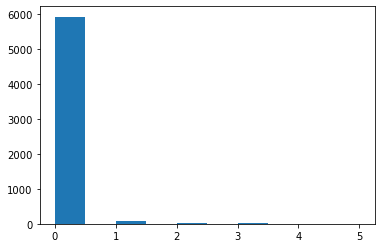

In [14]:
plt.hist(ratings["buy_level"], bins = np.arange(0,5.5,0.5))

(array([   0.,    0.,    0.,    0.,    0.,    0.,  217.,    0.,  159.,
        5674.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

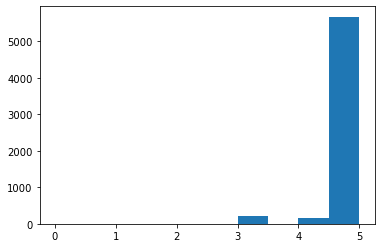

In [15]:
plt.hist(ratings["low_clac"], bins = np.arange(0,5.5,0.5))

(array([ 288.,    0.,  577.,    0.,  864.,    0., 1152.,    0., 1440.,
        1729.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

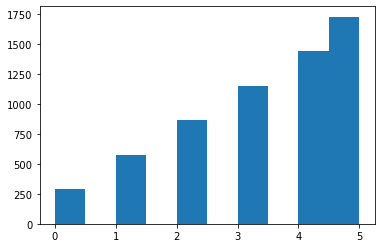

In [16]:
plt.hist(ratings["range_score"], bins = np.arange(0,5.5,0.5))

In [17]:
ratings["score"] = (ratings["buy_level"]*2 + ratings["low_clac"] + ratings["range_score"])/4

(array([   0.,   19.,  375., 1348., 2607., 1667.,   25.,    9.,    0.,
           0.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

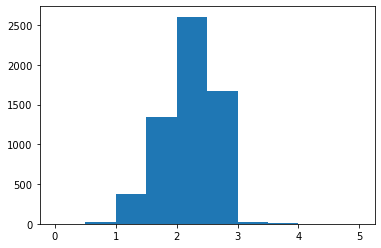

In [18]:
plt.hist(ratings["score"], bins = np.arange(0,5.5,0.5))

# 모델링

## LabelEncoding

In [19]:
le_c = LabelEncoder()
le_c = le_c.fit(ratings.cust)
ratings['cust']=le_c.transform(ratings.cust)
customer_info=pd.DataFrame(le_c.classes_, columns={'cust'})
customer_info['label']=range(0,len(ratings.cust.unique()))
customer_info.to_csv(aa+"_customer_info.csv",index=False)
customer_info

,cust,label
0,M000504230,0
1,M000508243,1
2,M000713279,2
3,M000859319,3
4,M001405587,4
...,...,...
3140,M998346579,3140
3141,M998579559,3141
3142,M999102910,3142
3143,M999340261,3143


In [20]:
le_p = LabelEncoder()
le_p = le_p.fit(ratings.pd_c)
ratings['pd_c']=le_p.transform(ratings.pd_c)
pd_info=pd.DataFrame(le_p.classes_, columns={'pd_c'})
pd_info['label']=range(0,len(ratings.pd_c.unique()))
pd_info.to_csv(aa+"_pd_info.csv",index=False)
pd_info

,pd_c,label
0,PD0006,0
1,PD0007,1
2,PD0008,2
3,PD0011,3
4,PD0027,4
...,...,...
226,PD1880,226
227,PD1901,227
228,PD1919,228
229,PD1924,229


In [21]:
# train test 분리
TRAIN_SIZE = 0.9
ratings = shuffle(ratings)
cutoff = int(TRAIN_SIZE * len(ratings))
ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.iloc[cutoff:]

In [22]:
users=A0.groupby(['cust','ages','ma_fem_dv'],as_index=False).count()
users=users[['cust','ages','ma_fem_dv']]
users['cust']=le_c.transform(users.cust)
users

,cust,ages,ma_fem_dv
0,0,30대,여성
1,1,50대,여성
2,2,50대,여성
3,3,70대,남성
4,4,30대,남성
...,...,...,...
3140,3140,40대,남성
3141,3141,40대,남성
3142,3142,50대,여성
3143,3143,50대,남성


In [23]:
ages=[]
for i in range(len(users)):
    users.ages[i]=users.ages[i][0:2]
users.ages=users.ages.astype('float')

<ipython-input-23-ab29fe5432dc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users.ages[i]=users.ages[i][0:2]


In [24]:
le_s = LabelEncoder()
le_s = le_s.fit(users.ma_fem_dv)
users['ma_fem_dv']=le_s.transform(users.ma_fem_dv)

customer_info['sex']=users['ma_fem_dv']
customer_info

,cust,label,sex
0,M000504230,0,1
1,M000508243,1,1
2,M000713279,2,1
3,M000859319,3,0
4,M001405587,4,0
...,...,...,...
3140,M998346579,3140,0
3141,M998579559,3141,0
3142,M999102910,3142,1
3143,M999340261,3143,0


In [25]:
users

,cust,ages,ma_fem_dv
0,0,30.0,1
1,1,50.0,1
2,2,50.0,1
3,3,70.0,0
4,4,30.0,0
...,...,...,...
3140,3140,40.0,0
3141,3141,40.0,0
3142,3142,50.0,1
3143,3143,50.0,0


In [26]:
L=len(customer_info)
train_asz = pd.merge(ratings_train, users, on='cust')[['ages','ma_fem_dv']]
test_asz = pd.merge(ratings_test, users, on='cust')[['ages','ma_fem_dv']]

## INPUT file (구매 경험이 없는 고객-상품 모음) 생성

In [27]:
ratings = pd.merge(ratings,users,how="left",on="cust")

#회귀분석을 이용한 score 관련 변수 확인하기
res = ols('score ~ ages+ma_fem_dv', data=ratings).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     10.82
Date:                Sat, 06 Aug 2022   Prob (F-statistic):           2.04e-05
Time:                        18:54:15   Log-Likelihood:                -3099.8
No. Observations:                6050   AIC:                             6206.
Df Residuals:                    6047   BIC:                             6226.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0256      0.019    105.282      0.000       1.988       2.063
ages           0.0006      0.000      1.330      0.183      -0.000       0.001
ma_fem_dv      0.0463      0.010      4.415      0.000       0.026       0.067
==============================================================================
Omnibus:                      290.403   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              333.215
Skew:                          -0.574   Prob(JB):                     4.40e-73
Kurtosis:                       3.065   Cond. No.                         154.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
ratings.to_csv(aa+"_ratings.csv",index=False,encoding='utf-8-sig')
users.to_csv(aa+"_users.csv",index=False)

In [29]:
check = np.zeros(shape=(len(ratings["cust"].unique()), len(ratings["pd_c"].unique())), dtype=np.int8) - 999


for i in tqdm_notebook(range(len(ratings))):
    c_label = ratings.iloc[i,0]
    p_label = ratings.iloc[i,1]
    sco = ratings.iloc[i,-1]
    check[int(c_label)][int(p_label)] = sco
    
cust = np.where(check == -999)[0]
pd_c = np.where(check == -999)[1]
last = pd.DataFrame()
last["cust"] = cust
last["pd_c"] = pd_c
last = pd.merge(last,users,how="left",on="cust")
last.to_csv(aa+"_input.csv",index=False)

<ipython-input-29-ee852db894de>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(ratings))):


  0%|          | 0/6050 [00:00<?, ?it/s]

## Model Fitting

In [30]:
# Variable 초기화 
K = 200                             # Latent factor 수 
mu = ratings_train.score.mean()    # 전체 평균 
M = ratings.cust.max() + 1       
N = ratings.pd_c.max() + 1  

In [31]:
# Keras model
user = Input(shape=(1, ))
item = Input(shape=(1, ))
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)

In [32]:
# Concatenate layers
P_embedding = Flatten()(P_embedding)
Q_embedding = Flatten()(Q_embedding)
user_bias = Flatten()(user_bias)
item_bias = Flatten()(item_bias)

In [33]:
age = Input(shape=(1, ))
age_embedding = Embedding(L, 3, embeddings_regularizer=l2())(age)
age_layer = Flatten()(age_embedding)

sex = Input(shape=(1, ))
sex_embedding = Embedding(L, 3, embeddings_regularizer=l2())(sex)
sex_layer = Flatten()(sex_embedding)

R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias, age_layer,sex_layer])

In [34]:
# Neural network
R = Dense(2048)(R)
R = Activation('relu')(R)
R = Dense(256)(R)
R = Activation('relu')(R)
R = Dense(1)(R)

In [35]:
model = Model(inputs=[user, item, age, sex], outputs=R)
model.compile(
  loss="mse",
  optimizer=SGD(),
  #optimizer=Adamax(),
  metrics=[RootMeanSquaredError()]
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                              

In [36]:
callbacks = [EarlyStopping(monitor='val_loss',
                                           patience=3),
             ModelCheckpoint(filepath=aa+'_best_model.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]

In [37]:
# Model fitting
result = model.fit(
  x=[ratings_train.cust.values, ratings_train.pd_c.values, train_asz.ages, train_asz.ma_fem_dv],
  y=ratings_train.score.values - mu,
  epochs=1000,
  batch_size=512,
  validation_data=(
    [ratings_test.cust.values, ratings_test.pd_c.values, test_asz.ages, test_asz.ma_fem_dv],
    ratings_test.score.values - mu
  ), callbacks = callbacks
)

Epoch 1/1000
11/11 [==============================] - 2s 53ms/step - loss: 5.9682 - root_mean_squared_error: 0.4059 - val_loss: 5.9455 - val_root_mean_squared_error: 0.3954
Epoch 2/1000
11/11 [==============================] - 0s 35ms/step - loss: 5.9426 - root_mean_squared_error: 0.4056 - val_loss: 5.9199 - val_root_mean_squared_error: 0.3952
Epoch 3/1000
11/11 [==============================] - 0s 34ms/step - loss: 5.9170 - root_mean_squared_error: 0.4054 - val_loss: 5.8945 - val_root_mean_squared_error: 0.3950
Epoch 4/1000
11/11 [==============================] - 0s 32ms/step - loss: 5.8916 - root_mean_squared_error: 0.4052 - val_loss: 5.8691 - val_root_mean_squared_error: 0.3948
Epoch 5/1000
11/11 [==============================] - 0s 33ms/step - loss: 5.8663 - root_mean_squared_error: 0.4050 - val_loss: 5.8439 - val_root_mean_squared_error: 0.3946
Epoch 6/1000
11/11 [==============================] - 0s 31ms/step - loss: 5.8411 - root_mean_squared_error: 0.4048 - val_loss: 5.8187 

11/11 [==============================] - 0s 30ms/step - loss: 4.8765 - root_mean_squared_error: 0.3963 - val_loss: 4.8568 - val_root_mean_squared_error: 0.3861
Epoch 49/1000
11/11 [==============================] - 0s 33ms/step - loss: 4.8556 - root_mean_squared_error: 0.3961 - val_loss: 4.8360 - val_root_mean_squared_error: 0.3858
Epoch 50/1000
11/11 [==============================] - 0s 34ms/step - loss: 4.8348 - root_mean_squared_error: 0.3959 - val_loss: 4.8152 - val_root_mean_squared_error: 0.3856
Epoch 51/1000
11/11 [==============================] - 0s 31ms/step - loss: 4.8141 - root_mean_squared_error: 0.3957 - val_loss: 4.7945 - val_root_mean_squared_error: 0.3854
Epoch 52/1000
11/11 [==============================] - 0s 31ms/step - loss: 4.7935 - root_mean_squared_error: 0.3954 - val_loss: 4.7740 - val_root_mean_squared_error: 0.3851
Epoch 53/1000
11/11 [==============================] - 0s 29ms/step - loss: 4.7729 - root_mean_squared_error: 0.3952 - val_loss: 4.7535 - val_ro

11/11 [==============================] - 0s 26ms/step - loss: 3.9852 - root_mean_squared_error: 0.3833 - val_loss: 3.9674 - val_root_mean_squared_error: 0.3723
Epoch 96/1000
11/11 [==============================] - 0s 26ms/step - loss: 3.9681 - root_mean_squared_error: 0.3829 - val_loss: 3.9504 - val_root_mean_squared_error: 0.3720
Epoch 97/1000
11/11 [==============================] - 0s 26ms/step - loss: 3.9510 - root_mean_squared_error: 0.3826 - val_loss: 3.9334 - val_root_mean_squared_error: 0.3716
Epoch 98/1000
11/11 [==============================] - 0s 26ms/step - loss: 3.9341 - root_mean_squared_error: 0.3822 - val_loss: 3.9164 - val_root_mean_squared_error: 0.3712
Epoch 99/1000
11/11 [==============================] - 0s 27ms/step - loss: 3.9172 - root_mean_squared_error: 0.3819 - val_loss: 3.8996 - val_root_mean_squared_error: 0.3709
Epoch 100/1000
11/11 [==============================] - 0s 27ms/step - loss: 3.9004 - root_mean_squared_error: 0.3815 - val_loss: 3.8828 - val_r

Epoch 142/1000
11/11 [==============================] - 0s 26ms/step - loss: 3.2550 - root_mean_squared_error: 0.3644 - val_loss: 3.2388 - val_root_mean_squared_error: 0.3524
Epoch 143/1000
11/11 [==============================] - 0s 27ms/step - loss: 3.2410 - root_mean_squared_error: 0.3639 - val_loss: 3.2248 - val_root_mean_squared_error: 0.3520
Epoch 144/1000
11/11 [==============================] - 0s 26ms/step - loss: 3.2271 - root_mean_squared_error: 0.3635 - val_loss: 3.2109 - val_root_mean_squared_error: 0.3515
Epoch 145/1000
11/11 [==============================] - 0s 27ms/step - loss: 3.2132 - root_mean_squared_error: 0.3631 - val_loss: 3.1971 - val_root_mean_squared_error: 0.3510
Epoch 146/1000
11/11 [==============================] - 0s 26ms/step - loss: 3.1994 - root_mean_squared_error: 0.3627 - val_loss: 3.1833 - val_root_mean_squared_error: 0.3506
Epoch 147/1000
11/11 [==============================] - 0s 26ms/step - loss: 3.1857 - root_mean_squared_error: 0.3622 - val_l

Epoch 189/1000
11/11 [==============================] - 0s 33ms/step - loss: 2.6595 - root_mean_squared_error: 0.3451 - val_loss: 2.6449 - val_root_mean_squared_error: 0.3328
Epoch 190/1000
11/11 [==============================] - 0s 31ms/step - loss: 2.6481 - root_mean_squared_error: 0.3447 - val_loss: 2.6336 - val_root_mean_squared_error: 0.3325
Epoch 191/1000
11/11 [==============================] - 0s 31ms/step - loss: 2.6368 - root_mean_squared_error: 0.3443 - val_loss: 2.6224 - val_root_mean_squared_error: 0.3322
Epoch 192/1000
11/11 [==============================] - 0s 28ms/step - loss: 2.6255 - root_mean_squared_error: 0.3440 - val_loss: 2.6111 - val_root_mean_squared_error: 0.3318
Epoch 193/1000
11/11 [==============================] - 0s 26ms/step - loss: 2.6143 - root_mean_squared_error: 0.3436 - val_loss: 2.5999 - val_root_mean_squared_error: 0.3314
Epoch 194/1000
11/11 [==============================] - 0s 27ms/step - loss: 2.6031 - root_mean_squared_error: 0.3432 - val_l

Epoch 236/1000
11/11 [==============================] - 0s 26ms/step - loss: 2.1756 - root_mean_squared_error: 0.3289 - val_loss: 2.1632 - val_root_mean_squared_error: 0.3176
Epoch 237/1000
11/11 [==============================] - 0s 28ms/step - loss: 2.1663 - root_mean_squared_error: 0.3286 - val_loss: 2.1540 - val_root_mean_squared_error: 0.3173
Epoch 238/1000
11/11 [==============================] - 0s 29ms/step - loss: 2.1571 - root_mean_squared_error: 0.3283 - val_loss: 2.1448 - val_root_mean_squared_error: 0.3169
Epoch 239/1000
11/11 [==============================] - 0s 29ms/step - loss: 2.1480 - root_mean_squared_error: 0.3280 - val_loss: 2.1358 - val_root_mean_squared_error: 0.3168
Epoch 240/1000
11/11 [==============================] - 0s 28ms/step - loss: 2.1388 - root_mean_squared_error: 0.3277 - val_loss: 2.1267 - val_root_mean_squared_error: 0.3165
Epoch 241/1000
11/11 [==============================] - 0s 30ms/step - loss: 2.1298 - root_mean_squared_error: 0.3274 - val_l

Epoch 283/1000
11/11 [==============================] - 0s 28ms/step - loss: 1.7826 - root_mean_squared_error: 0.3159 - val_loss: 1.7728 - val_root_mean_squared_error: 0.3068
Epoch 284/1000
11/11 [==============================] - 0s 28ms/step - loss: 1.7752 - root_mean_squared_error: 0.3158 - val_loss: 1.7652 - val_root_mean_squared_error: 0.3064
Epoch 285/1000
11/11 [==============================] - 0s 28ms/step - loss: 1.7676 - root_mean_squared_error: 0.3154 - val_loss: 1.7577 - val_root_mean_squared_error: 0.3060
Epoch 286/1000
11/11 [==============================] - 0s 28ms/step - loss: 1.7602 - root_mean_squared_error: 0.3153 - val_loss: 1.7505 - val_root_mean_squared_error: 0.3061
Epoch 287/1000
11/11 [==============================] - 0s 30ms/step - loss: 1.7528 - root_mean_squared_error: 0.3150 - val_loss: 1.7431 - val_root_mean_squared_error: 0.3059
Epoch 288/1000
11/11 [==============================] - 0s 28ms/step - loss: 1.7455 - root_mean_squared_error: 0.3148 - val_l

Epoch 330/1000
11/11 [==============================] - 0s 28ms/step - loss: 1.4636 - root_mean_squared_error: 0.3059 - val_loss: 1.4566 - val_root_mean_squared_error: 0.2997
Epoch 331/1000
11/11 [==============================] - 0s 29ms/step - loss: 1.4575 - root_mean_squared_error: 0.3057 - val_loss: 1.4503 - val_root_mean_squared_error: 0.2993
Epoch 332/1000
11/11 [==============================] - 0s 27ms/step - loss: 1.4515 - root_mean_squared_error: 0.3055 - val_loss: 1.4444 - val_root_mean_squared_error: 0.2993
Epoch 333/1000
11/11 [==============================] - 0s 29ms/step - loss: 1.4455 - root_mean_squared_error: 0.3054 - val_loss: 1.4384 - val_root_mean_squared_error: 0.2992
Epoch 334/1000
11/11 [==============================] - 0s 28ms/step - loss: 1.4394 - root_mean_squared_error: 0.3051 - val_loss: 1.4326 - val_root_mean_squared_error: 0.2993
Epoch 335/1000
11/11 [==============================] - 0s 28ms/step - loss: 1.4334 - root_mean_squared_error: 0.3049 - val_l

Epoch 377/1000
11/11 [==============================] - 0s 36ms/step - loss: 1.2043 - root_mean_squared_error: 0.2976 - val_loss: 1.1999 - val_root_mean_squared_error: 0.2947
Epoch 378/1000
11/11 [==============================] - 0s 31ms/step - loss: 1.1994 - root_mean_squared_error: 0.2975 - val_loss: 1.1950 - val_root_mean_squared_error: 0.2947
Epoch 379/1000
11/11 [==============================] - 0s 34ms/step - loss: 1.1944 - root_mean_squared_error: 0.2973 - val_loss: 1.1900 - val_root_mean_squared_error: 0.2944
Epoch 380/1000
11/11 [==============================] - 0s 31ms/step - loss: 1.1895 - root_mean_squared_error: 0.2971 - val_loss: 1.1852 - val_root_mean_squared_error: 0.2944
Epoch 381/1000
11/11 [==============================] - 0s 29ms/step - loss: 1.1846 - root_mean_squared_error: 0.2969 - val_loss: 1.1805 - val_root_mean_squared_error: 0.2946
Epoch 382/1000
11/11 [==============================] - 0s 30ms/step - loss: 1.1798 - root_mean_squared_error: 0.2968 - val_l

Epoch 424/1000
11/11 [==============================] - 0s 33ms/step - loss: 0.9931 - root_mean_squared_error: 0.2900 - val_loss: 0.9916 - val_root_mean_squared_error: 0.2913
Epoch 425/1000
11/11 [==============================] - 0s 30ms/step - loss: 0.9890 - root_mean_squared_error: 0.2898 - val_loss: 0.9877 - val_root_mean_squared_error: 0.2913
Epoch 426/1000
11/11 [==============================] - 0s 28ms/step - loss: 0.9850 - root_mean_squared_error: 0.2897 - val_loss: 0.9837 - val_root_mean_squared_error: 0.2913
Epoch 427/1000
11/11 [==============================] - 0s 32ms/step - loss: 0.9810 - root_mean_squared_error: 0.2895 - val_loss: 0.9799 - val_root_mean_squared_error: 0.2913
Epoch 428/1000
11/11 [==============================] - 0s 31ms/step - loss: 0.9770 - root_mean_squared_error: 0.2893 - val_loss: 0.9758 - val_root_mean_squared_error: 0.2911
Epoch 429/1000
11/11 [==============================] - 0s 31ms/step - loss: 0.9730 - root_mean_squared_error: 0.2892 - val_l

11/11 [==============================] - 0s 35ms/step - loss: 0.8238 - root_mean_squared_error: 0.2823 - val_loss: 0.8254 - val_root_mean_squared_error: 0.2883
Epoch 471/1000
11/11 [==============================] - 0s 28ms/step - loss: 0.8206 - root_mean_squared_error: 0.2822 - val_loss: 0.8223 - val_root_mean_squared_error: 0.2885
Epoch 472/1000
11/11 [==============================] - 0s 29ms/step - loss: 0.8172 - root_mean_squared_error: 0.2820 - val_loss: 0.8190 - val_root_mean_squared_error: 0.2882
Epoch 473/1000
11/11 [==============================] - 0s 29ms/step - loss: 0.8139 - root_mean_squared_error: 0.2818 - val_loss: 0.8165 - val_root_mean_squared_error: 0.2894
Epoch 474/1000
11/11 [==============================] - 0s 27ms/step - loss: 0.8107 - root_mean_squared_error: 0.2817 - val_loss: 0.8128 - val_root_mean_squared_error: 0.2886
Epoch 475/1000
11/11 [==============================] - 0s 28ms/step - loss: 0.8073 - root_mean_squared_error: 0.2814 - val_loss: 0.8094 - v

Epoch 517/1000
11/11 [==============================] - 0s 29ms/step - loss: 0.6819 - root_mean_squared_error: 0.2737 - val_loss: 0.6872 - val_root_mean_squared_error: 0.2858
Epoch 518/1000
11/11 [==============================] - 0s 30ms/step - loss: 0.6792 - root_mean_squared_error: 0.2736 - val_loss: 0.6846 - val_root_mean_squared_error: 0.2858
Epoch 519/1000
11/11 [==============================] - 0s 30ms/step - loss: 0.6764 - root_mean_squared_error: 0.2732 - val_loss: 0.6819 - val_root_mean_squared_error: 0.2857
Epoch 520/1000
11/11 [==============================] - 0s 29ms/step - loss: 0.6737 - root_mean_squared_error: 0.2730 - val_loss: 0.6792 - val_root_mean_squared_error: 0.2854
Epoch 521/1000
11/11 [==============================] - 0s 30ms/step - loss: 0.6710 - root_mean_squared_error: 0.2729 - val_loss: 0.6770 - val_root_mean_squared_error: 0.2862
Epoch 522/1000
11/11 [==============================] - 0s 30ms/step - loss: 0.6683 - root_mean_squared_error: 0.2726 - val_l

Epoch 564/1000
11/11 [==============================] - 0s 29ms/step - loss: 0.5651 - root_mean_squared_error: 0.2637 - val_loss: 0.5744 - val_root_mean_squared_error: 0.2828
Epoch 565/1000
11/11 [==============================] - 0s 30ms/step - loss: 0.5629 - root_mean_squared_error: 0.2634 - val_loss: 0.5724 - val_root_mean_squared_error: 0.2829
Epoch 566/1000
11/11 [==============================] - 0s 29ms/step - loss: 0.5609 - root_mean_squared_error: 0.2637 - val_loss: 0.5701 - val_root_mean_squared_error: 0.2828
Epoch 567/1000
11/11 [==============================] - 0s 29ms/step - loss: 0.5585 - root_mean_squared_error: 0.2630 - val_loss: 0.5681 - val_root_mean_squared_error: 0.2828
Epoch 568/1000
11/11 [==============================] - 0s 29ms/step - loss: 0.5562 - root_mean_squared_error: 0.2627 - val_loss: 0.5659 - val_root_mean_squared_error: 0.2827
Epoch 569/1000
11/11 [==============================] - 0s 30ms/step - loss: 0.5540 - root_mean_squared_error: 0.2626 - val_l

Epoch 611/1000
11/11 [==============================] - 0s 27ms/step - loss: 0.4688 - root_mean_squared_error: 0.2521 - val_loss: 0.4829 - val_root_mean_squared_error: 0.2803
Epoch 612/1000
11/11 [==============================] - 0s 30ms/step - loss: 0.4670 - root_mean_squared_error: 0.2519 - val_loss: 0.4809 - val_root_mean_squared_error: 0.2799
Epoch 613/1000
11/11 [==============================] - 0s 28ms/step - loss: 0.4651 - root_mean_squared_error: 0.2516 - val_loss: 0.4792 - val_root_mean_squared_error: 0.2799
Epoch 614/1000
11/11 [==============================] - 0s 28ms/step - loss: 0.4632 - root_mean_squared_error: 0.2512 - val_loss: 0.4774 - val_root_mean_squared_error: 0.2798
Epoch 615/1000
11/11 [==============================] - 0s 26ms/step - loss: 0.4614 - root_mean_squared_error: 0.2510 - val_loss: 0.4758 - val_root_mean_squared_error: 0.2799
Epoch 616/1000
11/11 [==============================] - 0s 29ms/step - loss: 0.4596 - root_mean_squared_error: 0.2508 - val_l

Epoch 658/1000
11/11 [==============================] - 0s 29ms/step - loss: 0.3892 - root_mean_squared_error: 0.2391 - val_loss: 0.4083 - val_root_mean_squared_error: 0.2776
Epoch 659/1000
11/11 [==============================] - 0s 27ms/step - loss: 0.3876 - root_mean_squared_error: 0.2388 - val_loss: 0.4069 - val_root_mean_squared_error: 0.2776
Epoch 660/1000
11/11 [==============================] - 0s 26ms/step - loss: 0.3861 - root_mean_squared_error: 0.2386 - val_loss: 0.4057 - val_root_mean_squared_error: 0.2779
Epoch 661/1000
11/11 [==============================] - 0s 26ms/step - loss: 0.3847 - root_mean_squared_error: 0.2385 - val_loss: 0.4041 - val_root_mean_squared_error: 0.2776
Epoch 662/1000
11/11 [==============================] - 0s 28ms/step - loss: 0.3831 - root_mean_squared_error: 0.2381 - val_loss: 0.4030 - val_root_mean_squared_error: 0.2782
Epoch 663/1000
11/11 [==============================] - 0s 26ms/step - loss: 0.3816 - root_mean_squared_error: 0.2377 - val_l

Epoch 705/1000
11/11 [==============================] - 0s 28ms/step - loss: 0.3233 - root_mean_squared_error: 0.2253 - val_loss: 0.3481 - val_root_mean_squared_error: 0.2760
Epoch 706/1000
11/11 [==============================] - 0s 28ms/step - loss: 0.3221 - root_mean_squared_error: 0.2250 - val_loss: 0.3470 - val_root_mean_squared_error: 0.2761
Epoch 707/1000
11/11 [==============================] - 0s 28ms/step - loss: 0.3208 - root_mean_squared_error: 0.2247 - val_loss: 0.3461 - val_root_mean_squared_error: 0.2765
Epoch 708/1000
11/11 [==============================] - 0s 27ms/step - loss: 0.3195 - root_mean_squared_error: 0.2243 - val_loss: 0.3447 - val_root_mean_squared_error: 0.2760
Epoch 709/1000
11/11 [==============================] - 0s 27ms/step - loss: 0.3184 - root_mean_squared_error: 0.2243 - val_loss: 0.3437 - val_root_mean_squared_error: 0.2761
Epoch 710/1000
11/11 [==============================] - 0s 27ms/step - loss: 0.3170 - root_mean_squared_error: 0.2238 - val_l

Epoch 752/1000
11/11 [==============================] - 0s 29ms/step - loss: 0.2691 - root_mean_squared_error: 0.2116 - val_loss: 0.2997 - val_root_mean_squared_error: 0.2755
Epoch 753/1000
11/11 [==============================] - 0s 28ms/step - loss: 0.2680 - root_mean_squared_error: 0.2112 - val_loss: 0.2989 - val_root_mean_squared_error: 0.2757
Epoch 754/1000
11/11 [==============================] - 0s 27ms/step - loss: 0.2670 - root_mean_squared_error: 0.2110 - val_loss: 0.2980 - val_root_mean_squared_error: 0.2758
Epoch 755/1000
11/11 [==============================] - 0s 29ms/step - loss: 0.2660 - root_mean_squared_error: 0.2108 - val_loss: 0.2970 - val_root_mean_squared_error: 0.2755
Epoch 756/1000
11/11 [==============================] - 0s 31ms/step - loss: 0.2650 - root_mean_squared_error: 0.2105 - val_loss: 0.2960 - val_root_mean_squared_error: 0.2755
Epoch 757/1000
11/11 [==============================] - 0s 29ms/step - loss: 0.2639 - root_mean_squared_error: 0.2101 - val_l

Epoch 799/1000
11/11 [==============================] - 0s 29ms/step - loss: 0.2246 - root_mean_squared_error: 0.1988 - val_loss: 0.2606 - val_root_mean_squared_error: 0.2756
Epoch 800/1000
11/11 [==============================] - 0s 29ms/step - loss: 0.2238 - root_mean_squared_error: 0.1985 - val_loss: 0.2599 - val_root_mean_squared_error: 0.2757
Epoch 801/1000
11/11 [==============================] - 0s 27ms/step - loss: 0.2229 - root_mean_squared_error: 0.1982 - val_loss: 0.2591 - val_root_mean_squared_error: 0.2756
Epoch 802/1000
11/11 [==============================] - 0s 30ms/step - loss: 0.2220 - root_mean_squared_error: 0.1980 - val_loss: 0.2584 - val_root_mean_squared_error: 0.2757
Epoch 803/1000
11/11 [==============================] - 0s 30ms/step - loss: 0.2212 - root_mean_squared_error: 0.1977 - val_loss: 0.2578 - val_root_mean_squared_error: 0.2758
Epoch 804/1000
11/11 [==============================] - 0s 27ms/step - loss: 0.2203 - root_mean_squared_error: 0.1975 - val_l

Epoch 846/1000
11/11 [==============================] - 0s 28ms/step - loss: 0.1884 - root_mean_squared_error: 0.1880 - val_loss: 0.2293 - val_root_mean_squared_error: 0.2767
Epoch 847/1000
11/11 [==============================] - 0s 29ms/step - loss: 0.1877 - root_mean_squared_error: 0.1878 - val_loss: 0.2287 - val_root_mean_squared_error: 0.2767
Epoch 848/1000
11/11 [==============================] - 0s 28ms/step - loss: 0.1870 - root_mean_squared_error: 0.1874 - val_loss: 0.2281 - val_root_mean_squared_error: 0.2767
Epoch 849/1000
11/11 [==============================] - 0s 27ms/step - loss: 0.1863 - root_mean_squared_error: 0.1871 - val_loss: 0.2278 - val_root_mean_squared_error: 0.2773
Epoch 850/1000
11/11 [==============================] - 0s 30ms/step - loss: 0.1857 - root_mean_squared_error: 0.1873 - val_loss: 0.2269 - val_root_mean_squared_error: 0.2768
Epoch 851/1000
11/11 [==============================] - 0s 31ms/step - loss: 0.1849 - root_mean_squared_error: 0.1868 - val_l

Epoch 893/1000
11/11 [==============================] - 0s 28ms/step - loss: 0.1590 - root_mean_squared_error: 0.1792 - val_loss: 0.2042 - val_root_mean_squared_error: 0.2784
Epoch 894/1000
11/11 [==============================] - 0s 27ms/step - loss: 0.1585 - root_mean_squared_error: 0.1790 - val_loss: 0.2035 - val_root_mean_squared_error: 0.2782
Epoch 895/1000
11/11 [==============================] - 0s 27ms/step - loss: 0.1579 - root_mean_squared_error: 0.1788 - val_loss: 0.2030 - val_root_mean_squared_error: 0.2782
Epoch 896/1000
11/11 [==============================] - 0s 30ms/step - loss: 0.1574 - root_mean_squared_error: 0.1789 - val_loss: 0.2027 - val_root_mean_squared_error: 0.2785
Epoch 897/1000
11/11 [==============================] - 0s 29ms/step - loss: 0.1568 - root_mean_squared_error: 0.1785 - val_loss: 0.2021 - val_root_mean_squared_error: 0.2783
Epoch 898/1000
11/11 [==============================] - 0s 28ms/step - loss: 0.1563 - root_mean_squared_error: 0.1785 - val_l

Epoch 940/1000
11/11 [==============================] - 0s 28ms/step - loss: 0.1353 - root_mean_squared_error: 0.1728 - val_loss: 0.1835 - val_root_mean_squared_error: 0.2797
Epoch 941/1000
11/11 [==============================] - 0s 30ms/step - loss: 0.1349 - root_mean_squared_error: 0.1726 - val_loss: 0.1832 - val_root_mean_squared_error: 0.2799
Epoch 942/1000
11/11 [==============================] - 0s 29ms/step - loss: 0.1344 - root_mean_squared_error: 0.1724 - val_loss: 0.1827 - val_root_mean_squared_error: 0.2798
Epoch 943/1000
11/11 [==============================] - 0s 29ms/step - loss: 0.1340 - root_mean_squared_error: 0.1726 - val_loss: 0.1823 - val_root_mean_squared_error: 0.2799
Epoch 944/1000
11/11 [==============================] - 0s 29ms/step - loss: 0.1335 - root_mean_squared_error: 0.1723 - val_loss: 0.1821 - val_root_mean_squared_error: 0.2802
Epoch 945/1000
11/11 [==============================] - 0s 27ms/step - loss: 0.1330 - root_mean_squared_error: 0.1721 - val_l

Epoch 987/1000
11/11 [==============================] - 0s 30ms/step - loss: 0.1161 - root_mean_squared_error: 0.1680 - val_loss: 0.1668 - val_root_mean_squared_error: 0.2813
Epoch 988/1000
11/11 [==============================] - 0s 28ms/step - loss: 0.1157 - root_mean_squared_error: 0.1679 - val_loss: 0.1664 - val_root_mean_squared_error: 0.2813
Epoch 989/1000
11/11 [==============================] - 0s 29ms/step - loss: 0.1154 - root_mean_squared_error: 0.1681 - val_loss: 0.1662 - val_root_mean_squared_error: 0.2814
Epoch 990/1000
11/11 [==============================] - 0s 29ms/step - loss: 0.1151 - root_mean_squared_error: 0.1680 - val_loss: 0.1659 - val_root_mean_squared_error: 0.2814
Epoch 991/1000
11/11 [==============================] - 0s 28ms/step - loss: 0.1147 - root_mean_squared_error: 0.1678 - val_loss: 0.1655 - val_root_mean_squared_error: 0.2814
Epoch 992/1000
11/11 [==============================] - 0s 29ms/step - loss: 0.1143 - root_mean_squared_error: 0.1678 - val_l

## 결과 확인

In [38]:
keras_model_best = load_model(aa+'_best_model.h5')

<Figure size 576x576 with 0 Axes>

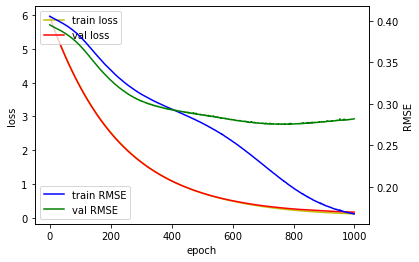

In [39]:
# Plot RMSE
plt.figure(figsize=(8,8))

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(result.history['loss'], 'y', label = 'train loss')
loss_ax.plot(result.history['val_loss'], 'r', label = 'val loss')

acc_ax.plot(result.history['root_mean_squared_error'], 'b', label = 'train RMSE')
acc_ax.plot(result.history['val_root_mean_squared_error'], 'g', label = 'val RMSE')


loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('RMSE')

loss_ax.legend(loc = 'upper left')
acc_ax.legend(loc = 'lower left')

plt.savefig(aa+'_model_loss.png')

In [40]:
# Prediction
user_ids = ratings_test.cust.values[100:110]
pd_ids = ratings_test.pd_c.values[100:110]
user_test = test_asz[100:110]
predictions = keras_model_best.predict([user_ids, pd_ids, user_test.ages, user_test.ma_fem_dv]) + mu
print("Actuals: \n", ratings_test[100:110]["score"])
print()
print("Predictions: \n", predictions)

Actuals: 
 5468    2.50
5604    2.00
4830    1.25
593     2.00
401     2.00
2408    2.50
3       2.00
2950    1.50
1208    1.75
1732    1.75
Name: score, dtype: float64

Predictions: 
 [[2.4399462]
 [1.980293 ]
 [1.3140476]
 [2.304014 ]
 [2.2058   ]
 [2.2695312]
 [2.0218072]
 [1.3855014]
 [1.7863885]
 [1.972409 ]]


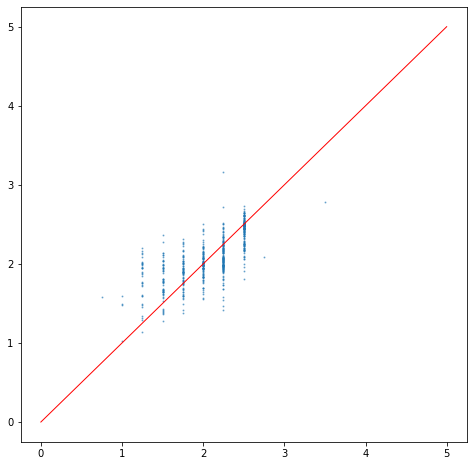

In [41]:
# Pred plot
user_ids = ratings_test.cust.values
pd_ids = ratings_test.pd_c.values
user_test = test_asz
predictions = keras_model_best.predict([user_ids, pd_ids, user_test.ages, user_test.ma_fem_dv]) + mu


plt.figure(figsize=(8,8))
plt.scatter(x = ratings_test.score, y = predictions, s=1, alpha = 0.5)
plt.plot([0, 5], [0, 5], color="red", lw=1, linestyle='solid')
plt.savefig(aa+'_test_predplot.png')

# OUTPUT file 생성

In [42]:
last["pred_score"] = keras_model_best.predict([last["cust"], last["pd_c"], last["ages"], last["ma_fem_dv"]]) + mu

In [43]:
last

,cust,pd_c,ages,ma_fem_dv,pred_score
0,0,0,30.0,1,1.404061
1,0,1,30.0,1,1.256365
2,0,2,30.0,1,1.540104
3,0,3,30.0,1,1.257600
4,0,4,30.0,1,1.299510
...,...,...,...,...,...
720440,3144,226,50.0,1,1.533986
720441,3144,227,50.0,1,1.672423
720442,3144,228,50.0,1,1.454478
720443,3144,229,50.0,1,1.566624


In [44]:
last.to_csv(aa+"_output.csv",index=False)